# Network Formation Games


## Importation des librairies

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random 
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import collections

## 1- Random Graph

In [7]:
def initEmptyGraph(N):
    G = nx.Graph()
    for i in range(N):
        G.add_node(i, value=0)
    return G

def createGraph(emptyGraph, p):
    G = emptyGraph
    for node in tqdm(list(G.nodes)):
        for n in list(G.nodes):
            if  n != node and random.uniform(0.0, 1.0) < p:
                G.add_edge(node,n)
    return G

def getSizeLargestComponent(G):
    return len(max(nx.connected_components(G), key=len))

def getSizeLargestClique(G):
    return nx.approximation.large_clique_size(G)

En premier test de nos fonctions de création de graph, on créé un graphe de 100 noeuds avec une probabilité de lien entre chaque noeud de 1%. On obtient les résultats suivants :

100%|██████████| 100/100 [00:00<00:00, 7726.02it/s]


Taille du plus grand groupe de noeuds interconnecté : 77 (77.0%)
Taille de la plus grande clique : 3 (3.0%)


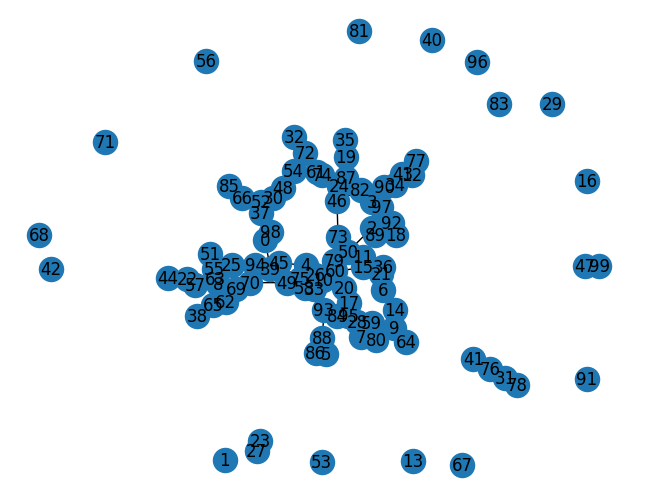

In [3]:
p = 0.01
N = 100

emptyG = initEmptyGraph(N)
G = createGraph(emptyG, p)

largest_component = getSizeLargestComponent(G)
pourcentage_component = ((largest_component)/N)*100

largest_clique = getSizeLargestClique(G)
pourcentage_clique = ((largest_clique)/N)*100

nx.draw(G,with_labels=True)
print(f"Taille du plus grand groupe de noeuds interconnecté : {largest_component} ({pourcentage_component}%)")
print(f"Taille de la plus grande clique : {largest_clique} ({pourcentage_clique}%)")

En utilisant nos propres fonctions pour créer les graphes, les temps d'execution sont beaucoup trop élevés pour générer les 1000 graphes. 

On décide donc d'utiliser les fonctions natives plus optimisées de NetworkX pour la suite du projet : _nx.gnp_random_graph(100, p)_.

On trace donc successivement 1000 graphes de 100 noeuds chacun en incrémentant la probabilité de lien entre les noeuds de 0,001 à chaque itération.

In [4]:
probabilities = []
largest_components = []
largest_cliques = []

for p in tqdm(np.arange(0, 1, 0.001)):
    G = nx.gnp_random_graph(100, p)
    probabilities.append(p)
    largest_components.append(getSizeLargestComponent(G))
    largest_cliques.append(getSizeLargestClique(G))

df = pd.DataFrame(zip(probabilities,largest_components,largest_cliques), columns=['Probability', 'Largest component size', 'Largest clique size'])
fig = px.bar(df, x='Probability', y='Largest component size')
fig.show()
fig = px.bar(df, x='Probability', y='Largest clique size')
fig.show()

100%|██████████| 1000/1000 [01:29<00:00, 11.19it/s]


On observe que la taille du plus grand groupe de noeud augmente extrêmement rapidement jusqu'à son maximum en **0,05 de probabilité**. Au dessus de ce seuil de probabilité, les graphes ont tous leurs noeuds interconnectés et aucun ne reste tout seul.

La clique d’un graphe est l’ensemble maximal de sommets formant un sous-graphe complet, c’est-à-dire un sous-graphe dont les sommets sont tous reliés deux à deux par une arête. Une clique permet d’identifier les groupes ou les communautés soudés au sein d’un graphe.

On observe sur le deuxième graphique que l'évolution de la taille de la plus grande clique en fonction de la probabilité à une allure exponentielle. Au dessus d'une probabilité de **0,8**, la taille augmente plus rapidement de 20 à 100. Ce graphique nous montre que plus la probabilité de lien augmente, plus les groupes formés par les noeuds sont importants.

## Degree Distribution

On décide maintenant de s'intéresser à la distribution des degrés.




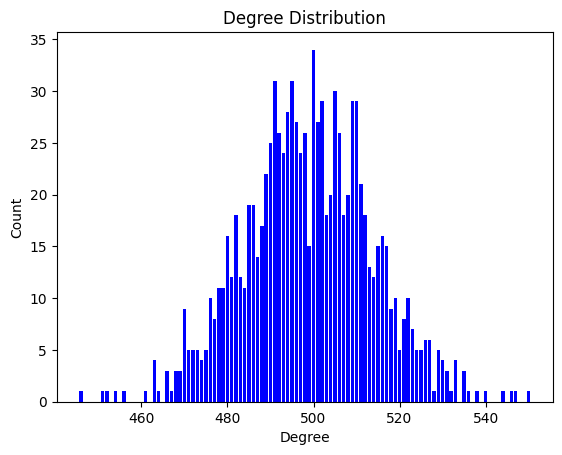

In [45]:
def degree_distrib(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())
    return deg, cnt

G = nx.gnp_random_graph(1000, 0.5)
deg, cnt = degree_distrib(G)

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [44]:

node_number = 100

degree_list = list(range(0,node_number+1))
x, y, z = [], [], []

for p in tqdm(np.arange(0, 1, 0.03)):
    count = [0] * (node_number+1)
    list_proba = [p] * (node_number+1)
    G = nx.gnp_random_graph(node_number, p)
    deg, cnt = degree_distrib(G)
    for i in range(0, len(deg)):
        count[deg[i]] = cnt[i]
    x += degree_list
    y += count
    z += list_proba

df = pd.DataFrame(list(zip(x,y,z)), columns = ['Degree','Count','Probability'])

fig = px.bar(df, x="Degree", y="Count", color="Count", animation_frame="Probability", range_y=[0,node_number/6])
fig.show()

100%|██████████| 34/34 [00:01<00:00, 28.59it/s] 


# 2- Simple graph formation game

Dans cette partie, nous créons une fonction permettant de calculer la "valeur" de chaque noeud dans le graphe à un instant *t*. Chaque valeur est calculée ainsi : 
- Si le noeud n'a pas de voisin sa valeur est **0**,
- Si le noeud a un seul et unique voisin sa valeur est **1**,
- Sinon la valeur du noeud est la **somme de la valeur de ses voisins**.

In [2]:
def compute_values(G, error=1):
    nodes = G.nodes
    for node in nodes:
        value = 0
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 1:
            value = 1
        else:
            for neighbor in neighbors:
                value += G.nodes[neighbor]['value']
        G.nodes[node]['value'] = value * error       

Ces valeurs nous permettent de choisir avec quel noeud doit être lié le noeud que l'on veut placer dans le graphe. Nous décidons ici de lier un noeud avec le noeud qui maximisera sa valeur. 

In [3]:
def simpleGraphFormation(N, inf=1, sup=1):
    G = initEmptyGraph(N)
    nodes = list(G.nodes)
    random.shuffle(nodes)
    for node in nodes:
        compute_values(G, random.uniform(inf, sup))
        values = nx.get_node_attributes(G, 'value')
        values.pop(node)
        max_value_node = max(values.items(), key=lambda n : n[1])
        if max_value_node[1] == 0:
            G.add_edge(node, random.randint(0, 100))
        else:
            G.add_edge(node, max_value_node[0])
    return G

Ces paramètres permettent de créer des graphes où tous les noeuds sont liés à un noeud central.

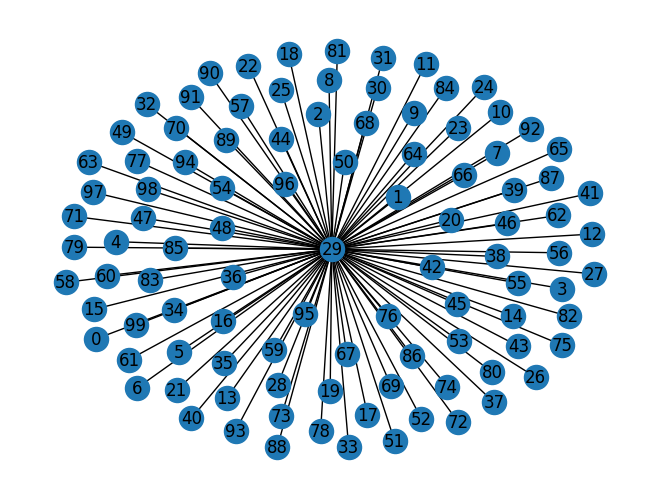

In [10]:
G = simpleGraphFormation(100)
nx.draw(G, with_labels=True)

Si on introduit une incertitude sur la valeur du noeud au moment du choix du placement (entre *50%* et *150%* de la valeur réelle), nous n'obtenons plus à chaque coup un graphe centré autour d'un noeud mais il arrive que parfois plusieurs clusters de noeuds se forment. 

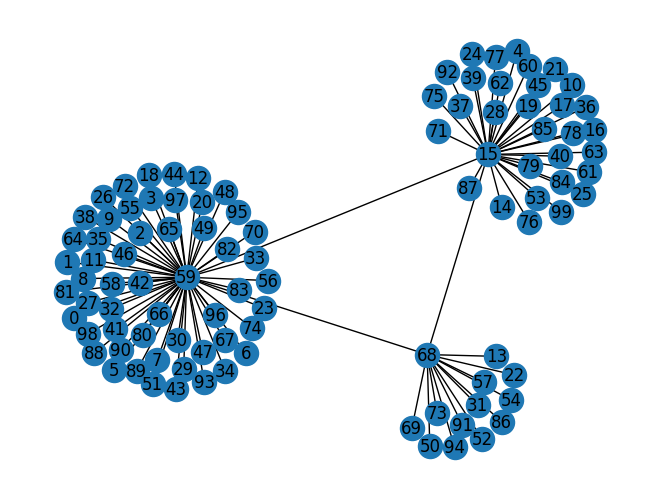

In [17]:
G = simpleGraphFormation(100, 0.5, 1.5)
nx.draw(G, with_labels=True)